In [ ]:
!pip install torch_lr_finder

In [ ]:
import pandas as pd
import os
import random
from collections import defaultdict
from PIL import Image
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from torch_lr_finder import LRFinder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import copy
import gc

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # para múltiples GPUs

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Semilla aleatoria establecida en {seed}")


def get_train_transform(img_size):
    # Data augmentations
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_val_transform(img_size):
    #Solo se normalizan y redimensionan las imagenes del test y val
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader, desc="Entrenando", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    loss = running_loss / len(loader)
    return loss, acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validando", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    loss = running_loss / len(loader)
    return loss, acc

In [ ]:
class SignLanguageDataset(Dataset):
    def __init__(self, file_list, label_map, transform=None):
        self.file_list = file_list
        self.transform = transform
        # El mapa de etiquetas se pasa desde fuera
        self.label_map = label_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        # La etiqueta es la carpeta
        letra = img_path.parent.name
        label = self.label_map[letra]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error cargando imagen {img_path}: {e}")
            return torch.randn(3, 224, 224), -1

        if self.transform:
            img = self.transform(img)
        return img, label

### Limpiar espacio de trabajo

In [ ]:
"""
!rm -rf /content/dataset_local
#Borrar memoria
del model
del train_dataset
del val_dataset
del test_dataset
del train_loader
del val_loader
del test_loader
gc.collect()
torch.cuda.empty_cache()
"""

'\n!rm -rf /content/dataset_local\n#Borrar memoria\ndel model\ndel train_dataset\ndel val_dataset\ndel test_dataset\ndel train_loader\ndel val_loader\ndel test_loader\ngc.collect()\ntorch.cuda.empty_cache()\n'

## Modelo Imágenes segmentadas (sin limpieza post-segmentación)

In [ ]:
print("Descomprimiendo dataset...")
!unzip -q "/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Imagenes_Segmentadas/Train_FondoNegro/imagenes_segmentadas_train_COMPLETO.zip" -d "/content/dataset_local/"

Descomprimiendo dataset...


In [ ]:
TRAIN_DIR = "/content/dataset_local"
# Split 90-5-5
VAL_SPLIT_SIZE = 0.05
TEST_SPLIT_SIZE = 0.05
BATCH_SIZE = 128
SEED = 42
IMG_SIZE = 224

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsando dispositivo: {device}")
if device.type == "cuda":
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")

print(f"Escaneando {TRAIN_DIR} para crear divisiones...")
train_root = Path(TRAIN_DIR)
all_files = []
all_labels_text = [] # Guardamos A, B, ... , Z

class_names = sorted([d.name for d in train_root.iterdir() if d.is_dir()])
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
NUM_CLASSES = len(class_names)

for class_name in class_names:
    class_dir = train_root / class_name
    files = list(class_dir.glob('*.[jp][pn]g'))
    all_files.extend(files)
    all_labels_text.extend([class_name] * len(files))

print(f"Total de imágenes encontradas: {len(all_files)}")
print(f"Número de clases: {NUM_CLASSES}")

size_val_test = VAL_SPLIT_SIZE + TEST_SPLIT_SIZE

train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files,
    all_labels_text,
    test_size=size_val_test,
    random_state=SEED,
    stratify=all_labels_text
)

#Se hace la division 5% de test-val
relative_test_size = TEST_SPLIT_SIZE / size_val_test

val_files, test_files, _, _ = train_test_split(
    temp_files,
    temp_labels,
    test_size=relative_test_size,
    random_state=SEED,
    stratify=temp_labels
)

print("\n--- ¡División completada! ---")
print(f"Imágenes de Entrenamiento: {len(train_files)} ({len(train_files)/len(all_files):.0%})")
print(f"Imágenes de Validación:   {len(val_files)} ({len(val_files)/len(all_files):.0%})")
print(f"Imágenes de Prueba:       {len(test_files)} ({len(test_files)/len(all_files):.0%})")

Semilla aleatoria establecida en 42

Usando dispositivo: cuda
GPU detectada: NVIDIA L4
Escaneando /content/dataset_local para crear divisiones...
Total de imágenes encontradas: 153886
Número de clases: 27

--- ¡División completada! ---
Imágenes de Entrenamiento: 138497 (90%)
Imágenes de Validación:   7694 (5%)
Imágenes de Prueba:       7695 (5%)


Semilla aleatoria establecida en 42
Usando 12 workers para cargar datos...

DataLoaders listos.
Clases: 27
Semilla aleatoria establecida en 42
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 231MB/s]



Iniciando LR Range Test para EfficientNet-B0...


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-03


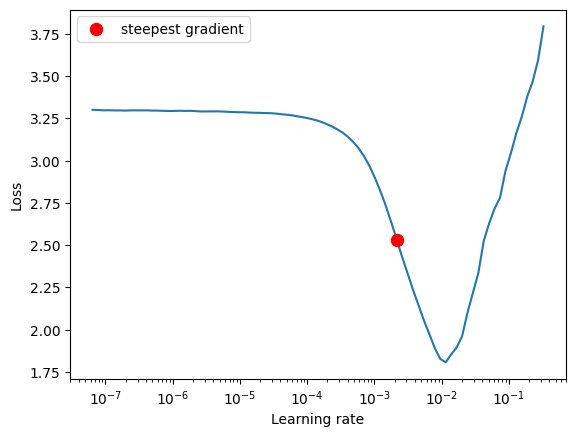

In [ ]:
set_seed(SEED)

train_tfm = get_train_transform(IMG_SIZE)
val_tfm = get_val_transform(IMG_SIZE)

train_dataset = SignLanguageDataset(train_files, label_map, transform=train_tfm)
val_dataset = SignLanguageDataset(val_files, label_map, transform=val_tfm)
test_dataset = SignLanguageDataset(test_files, label_map, transform=val_tfm)

num_cpus = os.cpu_count()

print(f"Usando {num_cpus} workers para cargar datos...")

# DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_cpus,  # Usa todos los CPUs
                          pin_memory=True,
                          prefetch_factor=2    # Precarga 2 lotes
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=num_cpus,
                        pin_memory=True,
                        prefetch_factor=2
                       )

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=num_cpus,
                         pin_memory=True,
                         prefetch_factor=2
                        )

print(f"\nDataLoaders listos.")
print(f"Clases: {NUM_CLASSES}")

# Búsqueda de LR
set_seed(SEED) # Resetear la semilla

model = models.efficientnet_b0(weights='IMAGENET1K_V1')

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-8)

print("\nIniciando LR Range Test para EfficientNet-B0...")
lr_finder = LRFinder(model, optimizer, criterion, device=device)
num_iter = min(100, len(train_loader) - 1)
lr_finder.range_test(train_loader, end_lr=1, num_iter=num_iter)

lr_finder.plot()
lr_finder.reset()

In [ ]:
LR = 2.15E-03 #LR encontrado arriba
EPOCHS = 50
set_seed(SEED)
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_weights = None

print(f"Iniciando entrenamiento de EfficientNet b0 con LR={LR}...")
patience = 10
patience_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Época {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"  -> Nuevo mejor modelo encontrado (Val Loss: {val_loss:.4f}). Guardando pesos.")
    else:
        # Si no mejora, aumentamos el contador de paciencia
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  -> No mejora en {patience} épocas. Deteniendo entrenamiento.")
            break

print("\nEntrenamiento finalizado.")

# Evaluación en Test
print(f"Cargando el mejor modelo (Val Loss: {best_val_loss:.4f}) para la prueba final...")
model.load_state_dict(best_model_weights)

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Probando en Test Set"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas finales
final_loss_ef2 = test_loss / len(test_loader)
final_acc_ef2 = accuracy_score(all_labels, all_preds) * 100
final_f1_ef2 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Resultados Finales (EfficientNetb0) ---")
print(f"  -> Test Loss:      {final_loss_ef2:.4f}")
print(f"  -> Test Accuracy:  {final_acc_ef2:.2f}%")
print(f"  -> Test F1-Score (Macro): {final_f1_ef2:.4f}")
print("---------------------------------------")

# Guardar modelo
torch.save(model.state_dict(), 'efficientNet_sign_language_seg.pth')




Semilla aleatoria establecida en 42
Iniciando entrenamiento de EfficientNet b0 con LR=0.00215...


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 1/50 -> Train Loss: 0.0669, Train Acc: 98.25% | Val Loss: 0.0461, Val Acc: 98.47%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.0461). Guardando pesos.


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 2/50 -> Train Loss: 0.0242, Train Acc: 99.39% | Val Loss: 0.0129, Val Acc: 99.61%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.0129). Guardando pesos.


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 3/50 -> Train Loss: 0.0230, Train Acc: 99.48% | Val Loss: 0.1431, Val Acc: 96.98%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 4/50 -> Train Loss: 0.0223, Train Acc: 99.52% | Val Loss: 0.0072, Val Acc: 99.82%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.0072). Guardando pesos.


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 5/50 -> Train Loss: 0.0169, Train Acc: 99.64% | Val Loss: 0.0077, Val Acc: 99.69%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 6/50 -> Train Loss: 0.0165, Train Acc: 99.65% | Val Loss: 0.0088, Val Acc: 99.70%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 7/50 -> Train Loss: 0.0154, Train Acc: 99.69% | Val Loss: 0.0019, Val Acc: 99.94%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.0019). Guardando pesos.


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 8/50 -> Train Loss: 0.0161, Train Acc: 99.71% | Val Loss: 0.0086, Val Acc: 99.74%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 9/50 -> Train Loss: 0.0138, Train Acc: 99.71% | Val Loss: 0.0398, Val Acc: 99.04%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 10/50 -> Train Loss: 0.0133, Train Acc: 99.71% | Val Loss: 0.0090, Val Acc: 99.71%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 11/50 -> Train Loss: 0.0124, Train Acc: 99.74% | Val Loss: 0.0047, Val Acc: 99.88%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 12/50 -> Train Loss: 0.0116, Train Acc: 99.75% | Val Loss: 0.0927, Val Acc: 97.87%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 13/50 -> Train Loss: 0.0116, Train Acc: 99.75% | Val Loss: 0.0016, Val Acc: 99.95%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.0016). Guardando pesos.


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 14/50 -> Train Loss: 0.0112, Train Acc: 99.73% | Val Loss: 0.0068, Val Acc: 99.79%


Entrenando:   0%|          | 0/1083 [00:00<?, ?it/s]

Validando:   0%|          | 0/61 [00:00<?, ?it/s]

Época 15/50 -> Train Loss: 0.0105, Train Acc: 99.79% | Val Loss: 0.0146, Val Acc: 99.61%
  -> No mejora en 10 épocas. Deteniendo entrenamiento.

Entrenamiento finalizado.
Cargando el mejor modelo (Val Loss: 0.0016) para la prueba final...


Probando en Test Set:   0%|          | 0/61 [00:00<?, ?it/s]


--- Resultados Finales (EfficientNetb0) ---
  -> Test Loss:      0.0033
  -> Test Accuracy:  99.88%
  -> Test F1-Score (Macro): 0.9988
---------------------------------------


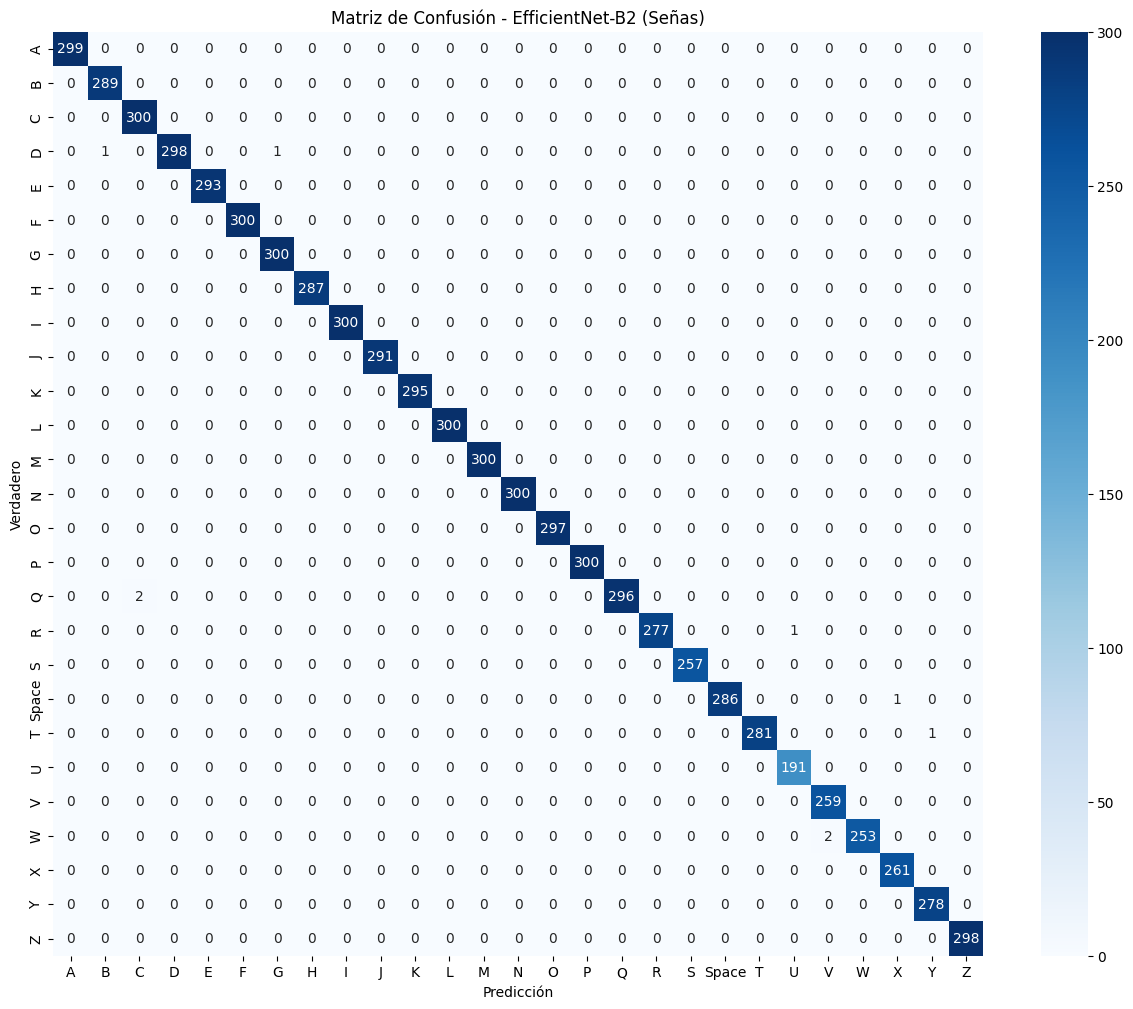

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.label_map.keys(),  # Usar los nombres de clases
            yticklabels=train_dataset.label_map.keys()) # Usar los nombres de clases
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - EfficientNet-B2 (Señas)')
plt.show()